# **Install** **required** **libraries**

In [1]:
!pip install tensorflow-text
!pip install tf-models-official
!pip install nltk

     |████████████████████████████████| 4.4 MB 5.4 MB/s 
     |████████████████████████████████| 458.3 MB 12 kB/s 
     |████████████████████████████████| 462 kB 45.4 MB/s 
     |████████████████████████████████| 5.6 MB 22.6 MB/s 
     |████████████████████████████████| 1.3 MB 27.2 MB/s 
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30692 sha256=89815db35c720ac61af0809ee812d5d551d22271707dbd97faeb3f089e9b3baf
  Stored in directory: /root/.cache/pip/wheels/98/91/04/971b4c587cf47ae952b108949b46926f426c02832d120a082a
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68719 sha256=7221501be97de0854b9135ff646496d8be1d7fd6f91132be21b8639540e4238c
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built clang wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Success

# **Text** **cleaner** **definition**

In [3]:
import string
import nltk
nltk.download("stopwords")
stopwords = nltk.corpus.stopwords.words('english')

class text_cleaner:
  def remove_punctuation(self, text):
    new_text = ''
    for char in text:
      if char in string.punctuation:
        new_text += ' '
      else:
        new_text += char
    return new_text

  def lowering(self, text):
    return text.lower()

  def clean(self, text):
    text = self.remove_punctuation(text)
    text = self.lowering(text)
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import os

# **Data** **loading**

In [4]:
import pandas as pd

data = pd.read_csv('/content/apple-twitter-sentiment-texts.csv', encoding='latin1')
data.columns = ['text','sentiment']
data = data.drop_duplicates().reset_index(drop=True)

In [5]:
data.shape

(1624, 2)

In [6]:
data.head(20)

,text,sentiment
0,Wow. Yall needa step it up @Apple RT @heynyla:...,-1
1,What Happened To Apple Inc? http://t.co/FJEX...,0
2,Thank u @apple I can now compile all of the pi...,1
3,The oddly uplifting story of the Apple co-foun...,0
4,@apple can i exchange my iphone for a differen...,0
5,RT @JPDesloges: Apple Acted Unfairly In Suppre...,-1
6,Let's not forget that press effects stock @App...,0
7,Apple Inc. Deleted Songs From Rival Services F...,-1
8,@TeamCavuto @Apple They're staging a die in ar...,0
9,Happy Monday! My camera on my fancy @Apple #iP...,-1


# **Data** **cleaning**

In [7]:
cleaner = text_cleaner()
data['text'] = data['text'].apply(lambda a:cleaner.clean(a))

In [8]:
data.head(20)

,text,sentiment
0,wow yall needa step it up apple rt heynyla ...,-1
1,what happened to apple inc http t co fjex...,0
2,thank u apple i can now compile all of the pi...,1
3,the oddly uplifting story of the apple co foun...,0
4,apple can i exchange my iphone for a differen...,0
5,rt jpdesloges apple acted unfairly in suppre...,-1
6,let s not forget that press effects stock app...,0
7,apple inc deleted songs from rival services f...,-1
8,teamcavuto apple they re staging a die in ar...,0
9,happy monday my camera on my fancy apple ip...,-1


# **Data** **shuffling**

In [12]:
data = data.sample(frac=1).reset_index(drop = True)

# **Data** **splitting**

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split

X = data['text'].values
y = data['sentiment'].values

new_y = []
for value in y:
    if value == -1:
        new_y.append([1,0,0])
    elif value== 0:
        new_y.append([0,1,0])
    else:
        new_y.append([0,0,1])

y = np.array(new_y)


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

In [14]:
import os

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

tf.get_logger().setLevel('ERROR')

# **Downloading** **layers**

In [20]:
bert_preprocess_model = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_model = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1", trainable=True)

# **Model** **definition**

In [21]:
# Model definition

def build_classifier_model():
  # Input layer 
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

  # Tokenizer layer 
  encoder_inputs = bert_preprocess_model(text_input)

  # Pretrained bert layer
  outputs = bert_model(encoder_inputs)

  # Get pooled output of bert
  net = outputs['pooled_output']

  net = tf.keras.layers.Dropout(0.3)(net)
  # Classification layer
  net = tf.keras.layers.Dense(3, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)


# **Training**

In [22]:
checkpoint_path = "model.ckpt"

tf.keras.backend.clear_session()
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                monitor = 'val_accuracy',
                                                verbose=0)

es_callback = tf.keras.callbacks.EarlyStopping(
monitor='val_loss', min_delta=0, patience=1, verbose=0,
mode='min', baseline=None, restore_best_weights=True)

classifier_model = build_classifier_model()
classifier_model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-4),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

history = classifier_model.fit(x = X_train,y=y_train,validation_data=(X_val, y_val),
                              epochs=200,batch_size = 32, callbacks = [cp_callback, es_callback])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
36/36 [==============================] - 25s 462ms/step - loss: 0.7020 - accuracy: 0.7386 - val_loss: 0.5287 - val_accuracy: 0.7951
Epoch 2/200
36/36 [==============================] - 16s 445ms/step - loss: 0.4393 - accuracy: 0.8371 - val_loss: 0.4307 - val_accuracy: 0.8361
Epoch 3/200
36/36 [==============================] - 16s 443ms/step - loss: 0.2210 - accuracy: 0.9173 - val_loss: 0.4819 - val_accuracy: 0.8443


# **Plotting** **results**

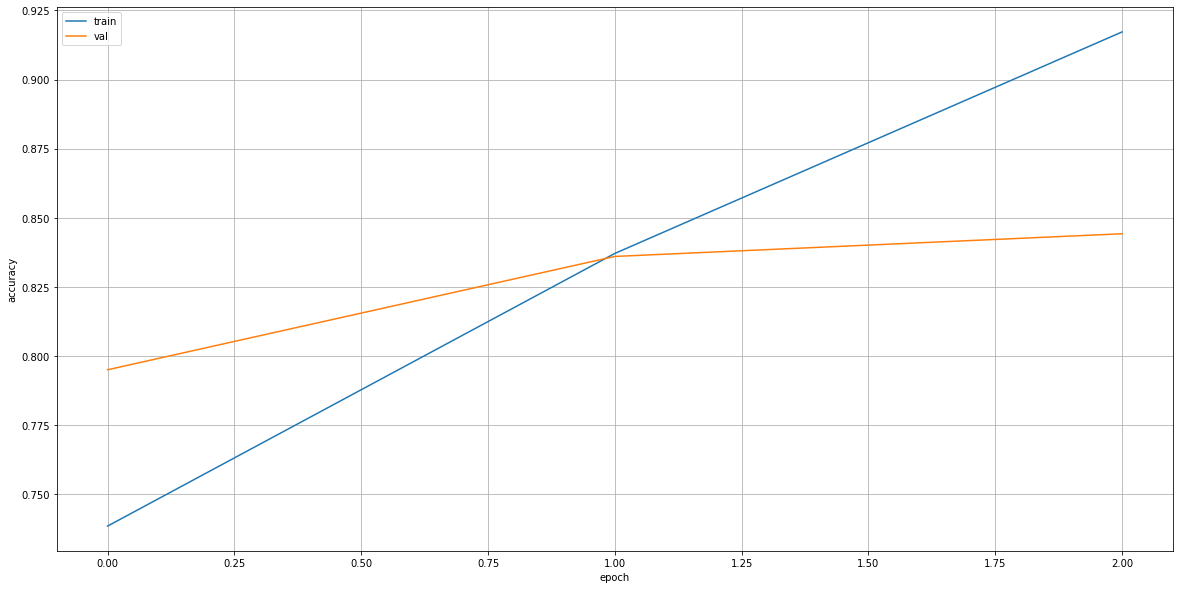

In [23]:
from matplotlib import pyplot as plt

fig, ax1 = plt.subplots(1, figsize = (20,10))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')
ax1.grid()

fig.show()

# **Moldel** **evaluation**

In [24]:
classifier_model.load_weights("model.ckpt")

res = classifier_model.evaluate(X_test, y_test, verbose=0)

print(f"Mean loss: {round(res[0], 2)}")
print(f"Mean acc: {round(res[1]*100, 2)}%")

Mean loss: 0.44
Mean acc: 88.11%


In [25]:
from sklearn.metrics import classification_report

predicted = classifier_model.predict(X_test)
predicted = np.array(list(map(lambda a:[0 if i!=np.argmax(a) else 1 for i in range(3)], predicted)))

print(classification_report(np.argmax(y_test, axis=1), np.argmax(predicted, axis = 1)))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90        96
           1       0.88      0.93      0.90       120
           2       0.78      0.64      0.71        28

    accuracy                           0.88       244
   macro avg       0.86      0.82      0.84       244
weighted avg       0.88      0.88      0.88       244



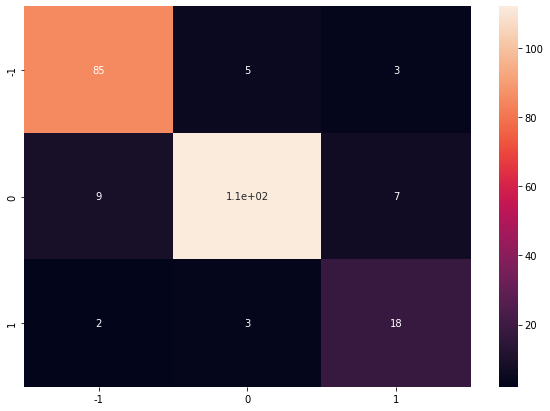

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(confusion_matrix(np.argmax(predicted, axis = 1), np.argmax(y_test, axis=1)), index = ['-1','0','1'],
                  columns = ['-1','0','1'])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

## **Naive Bayes**

# Use NLTK package

In [52]:
# preprocessing
import nltk
#nltk.download()

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = nltk.word_tokenize(text)
    return [lemmatizer.lemmatize(w).lower() for w in text if lemmatizer.lemmatize(w).lower() not in stop_words and w.isalpha()]

## **Spliting the data for evaluating Naive Bayes model**

In [53]:
# split data to training and test datasets, 70/30
import numpy as np
n = len(data)
# print (n)
np.random.seed(3)
idx = np.random.choice(range(n), round(n*0.85), replace=False)
minus_idx = np.setdiff1d(range(n), idx)

train = data.iloc[idx, ]
test = data.iloc[minus_idx, ]
print (train.shape)
print (test.shape)

(1380, 2)
(244, 2)


In [55]:
train

,text,sentiment
1075,fuck you apple iphone,-1
157,as a die hard apple customer i must say i am...,-1
154,here s how jimmy iovine convinced apple to bu...,0
671,loving the samsung one with kristen bell rt ...,0
343,details of the apple inc ipad mini 4 revealed...,0
...,...,...
1400,apple dec 5 trading daily profit 1 57 sh we...,0
259,cnbctv bulls running with gopro amp appl...,0
282,aapl lawsuit apple deleted songs from ipods...,-1
634,fuck apple for allowing ppl to access the came...,-1


In [56]:
import sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
from sklearn.naive_bayes import MultinomialNB

pipeline = Pipeline([
    ('vec', TfidfVectorizer(tokenizer=preprocess)),
    ('cls', MultinomialNB())
])

para = {
    'vec__binary': (True, False),
    'vec__ngram_range': ((1, 1), (1, 2), (2, 2)),
    'cls__alpha': (1, 0.1, 0.01, 0.001)
}

grid = GridSearchCV(pipeline, para, cv=5, iid=False, verbose=5, n_jobs=-1)
grid.fit(train["text"], train["sentiment"])





Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   58.9s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        nor

In [65]:
y_true = test['sentiment']
y_pred = grid.predict(test['text'])


In [77]:
target_names = [ '0', '1','2']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.78      0.87      0.82       112
           1       0.79      0.83      0.81       112
           2       1.00      0.15      0.26        20

    accuracy                           0.79       244
   macro avg       0.86      0.62      0.63       244
weighted avg       0.81      0.79      0.77       244

